In [ ]:
pip install shap

# Lectura de archivos

In [ ]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1FAjcexe-71nGuYIzvnQ46IdXVcqM9cx4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values_complete_features.csv')

test_values1 = pd.read_csv('test_values_complete_features.csv', encoding='latin-1', index_col='building_id')

test_values1[test_values1.select_dtypes('O').columns] = test_values1[test_values1.select_dtypes('O').columns].astype('category')

In [ ]:
id = '1qs2mEnkqiAqebJE2SvqkrfoV66Edguwr'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values_complete_features.csv')

train_values1 = pd.read_csv('train_values_complete_features.csv', encoding='latin-1', index_col='building_id')

train_values1[train_values1.select_dtypes('O').columns] = train_values1[train_values1.select_dtypes('O').columns].astype('category')

In [ ]:
id='1RUtolRcQlR3RGULttM4ZoQaK_Ouow4gc'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_labels.csv')
train_labels = pd.read_csv('train_labels.csv', encoding='latin-1', dtype={'building_id': 'int64', 'damage_grade': 'int64'}, index_col='building_id')

In [ ]:
id='1br3fMwXX_J0XmiXvOm_wfKWvHSj45T3y'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')
train_values2 = pd.read_csv('train_values.csv', encoding='latin-1', index_col='building_id')

train_values2[train_values2.select_dtypes('O').columns] = train_values2[train_values2.select_dtypes('O').columns].astype('category')

In [ ]:
id = '1kt2VFhgpfRS72wtBOBy1KDat9LanfMZU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values.csv')
test_values2 = pd.read_csv('test_values.csv', encoding='latin-1', index_col='building_id')

test_values2[test_values2.select_dtypes('O').columns] = test_values2[test_values2.select_dtypes('O').columns].astype('category')

In [ ]:
train_values_complete = train_values1.copy()
test_values_complete = test_values1.copy()
train_values_incomplete = train_values2.copy()
test_values_incomplete = test_values2.copy()

# LightGBM

In [ ]:
train_values = train_values_incomplete.copy()
test_values = test_values_incomplete.copy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def get_obj(train, p = False):
    obj_types = []
    for column in train.columns:
        if column in train.select_dtypes('category').columns: 
            if p: print(column)
            obj_types.append(column)
    return obj_types
    
obj_types = get_obj(train_values, True)

land_surface_condition
foundation_type
roof_type
ground_floor_type
other_floor_type
position
plan_configuration
legal_ownership_status


In [ ]:
pd.Categorical(train_values['ground_floor_type']).categories

Index(['f', 'm', 'v', 'x', 'z'], dtype='object')

In [ ]:
def transform_to_int(train, obj_types):
    #Assign dictionaries with current values and replacements for each column
    d_lsc = {'n':0, 'o':1, 't':2}
    d_ft = {'h':0, 'i':1, 'r':2, 'u':3, 'w':4}
    d_rt = {'n':0, 'q':1, 'x':2}
    d_gft = {'f':0, 'm':1, 'v':2, 'x':3, 'z':4}
    d_oft = {'j':0, 'q':1, 's':2, 'x':3}
    d_pos = {'j':0, 'o':1, 's':2, 't':3}
    d_pc = {'a':0, 'c':1, 'd':2, 'f':3, 'm':4, 'n':5, 'o':6, 'q':7, 's':8, 'u':9}
    d_los = {'a':0, 'r':1, 'v':2, 'w':3}
    #d_ra = {'actual':0, 'historic':1, 'new':2, 'old':3, 'regular':4, 'regular_old':5}
    #Each positional index in replacements corresponds to the column in obj_types
    replacements = [d_lsc, d_ft, d_rt, d_gft, d_oft, d_pos, d_pc, d_los]

    
      #Replace using lambda Series.map(lambda)
    for i,col in enumerate(obj_types):
      train[col] = train[col].map(lambda a: replacements[i][a]).astype('int64')
    
      

transform_to_int(train_values, obj_types)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_values, train_labels)

rcf = RandomForestClassifier()
model = rcf.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
y_pred = model.predict(x_test)
f1_score(y_test, y_pred,average='micro')

0.7197126674955104

In [ ]:
importance = pd.DataFrame({"Feature":list(train_values), "Importance": rcf.feature_importances_}) # build a dataframe with features and their importance
importance = importance.sort_values(by="Importance", ascending=False) #sort by importance
importance

,Feature,Importance
2,geo_level_3_id,0.153588
0,geo_level_1_id,0.139090
1,geo_level_2_id,0.134644
4,age,0.121624
5,area_percentage,0.111312
6,height_percentage,0.055921
26,count_families,0.025222
9,roof_type,0.024796
8,foundation_type,0.024129
12,position,0.021544


Elimino outliers de los parámetros más importantes

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

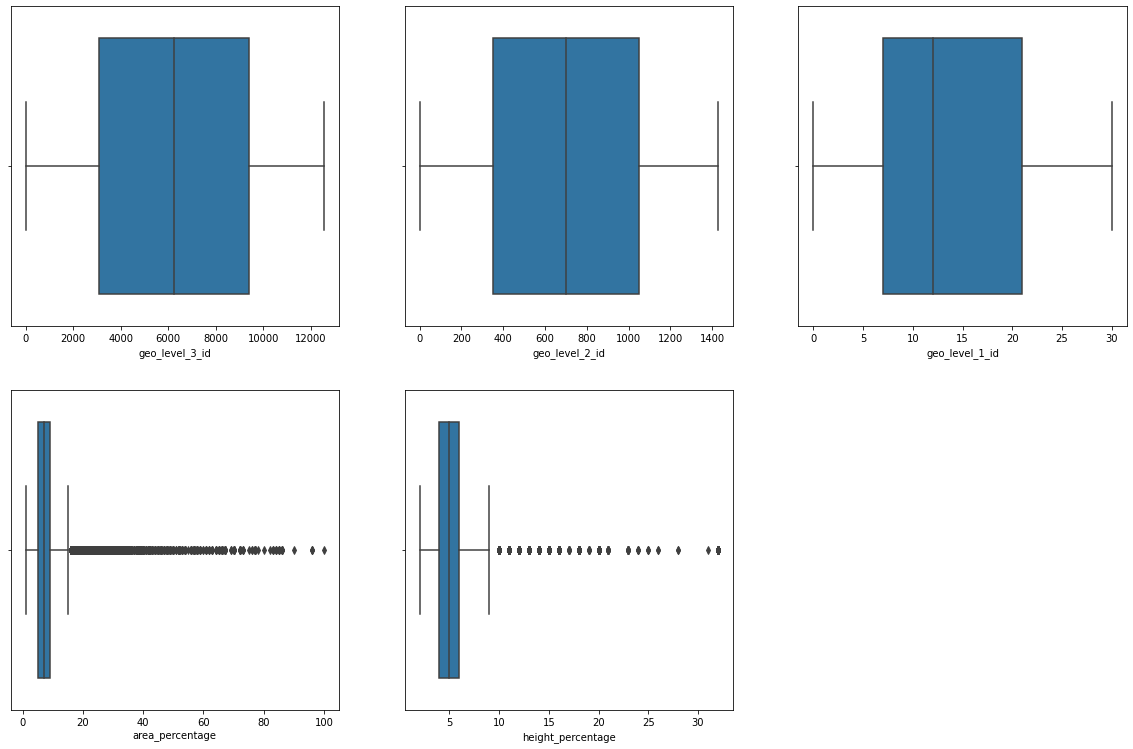

In [ ]:
boxplot_cols=["geo_level_3_id","geo_level_2_id","geo_level_1_id", "area_percentage", "height_percentage"]
q=1
plt.figure(figsize=(20,20))
for j in boxplot_cols:
    plt.subplot(3,3,q)
    ax=sns.boxplot(train_values[j].dropna())
    plt.xlabel(j)
    q+=1
plt.show()

Se aprecia que para los de `geo_level_id` no hay outliers, pero para los otros 3 si.

In [ ]:
import scipy

def remove_outliers(df, col_cutoff = 0.01, z_score = 3.5): #define a function to get rid of all outliers of the most important columns
    important_cols = importance[importance.Importance>col_cutoff]['Feature'].tolist() #get all columns with importance > 0.01.  
    df_new = df.copy() #init the new df
    for col in important_cols: df_new = df_new[np.abs(scipy.stats.zscore(df_new[col]))<z_score] #removing all rows where a z-score is >3
    return df_new

In [ ]:
df = pd.concat([train_values, train_labels], axis = 1)

In [ ]:
df_new = remove_outliers(df)

In [ ]:
y = df_new.pop('damage_grade')
x = df_new

In [ ]:
def get_original():
    df = train_values_incomplete.copy()
    #df.drop('building_id', axis =1, inplace=True)
    obj_types = get_obj(df)
    transform_to_int(df, obj_types)
    df['damage_grade'] = train_labels.damage_grade

    return df
    
df = get_original()

In [ ]:
#función para volver a dividir df en train_values y train_labels
def get_xy(df):
    y = df.pop('damage_grade')
    x= df
    return x, y

x,y = get_xy(df) 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 9)

In [ ]:
!pip uninstall lightgbm

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm-2.2.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/lightgbm/*
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install lightgbm --install-option=--gpu


/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5 MB 8.0 MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
y
    Running setup.py install for lightgbm ... done


In [ ]:
import lightgbm as lgb

In [ ]:
def test_model(model, removing = False, col_cutoff = 0.01, z_score = 3.5):
    df_train = pd.concat([x_train, y_train], axis = 1) #combine them together, so outliers are simultaneously removed from both
    if removing: df_train = remove_outliers(df_train, col_cutoff, z_score) 
    x, y = get_xy(df_train)
    model.fit(x, y)

    y_pred = model.predict(x_test)
    print(f1_score(y_test, y_pred, average='micro'))

In [ ]:
test_model(lgb.LGBMClassifier())

0.712040009721032


In [ ]:
def run_lightgmb(x_train, x_test, y_train, y_test, params={}):
  lgb_classifier = lgb.LGBMClassifier(**params)
  lgb_classifier.fit(x_train, y_train.values.ravel())

  pred = lgb_classifier.predict(x_test)
  score = f1_score(y_test, pred, average='micro')
  #score = accuracy_score(y_test, pred)

  cm = confusion_matrix(y_test, pred)
  #report = classification_report(y_test, pred)

  print("f1_micro: ", score, "\n\n")
  print(cm, "\n\n")
  #print(report, "\n\n")

  #return pred
  return lgb_classifier

In [ ]:
# Con estos parametros --> f1_micro:  0.7469398718391466 
# Con el dataset Normal
best_3 = {
    'device':"gpu",
    'objective': 'multiclass',
    'num_class':3,
    'is_unbalanced':True,
    'learning_rate': 0.26,
    'num_leaves':30,
    'max_depth':16,
    'n_estimators':1300,
    'lambda_l1':1.4,
    'lambda_l2':10,
    'min_data_in_leaf':22,
    'min_child_weight': 0.4,
    'feature_fraction': 0.57,
    'bagging_fraction': 0.76
}

In [ ]:
model = run_lightgmb(x_train, x_test, y_train, y_test, best_3)
#test_model(LGBM_classifier)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.57, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.57
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] lambda_l1 is set=1.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
f1_micro:  0.743288011153605 


[[ 3935  3440   126]
 [ 1687 37373  5387]
 [  169  9261 16803]] 




In [ ]:
lg_classifier = lgb.LGBMClassifier(**best_3)
test_model(lg_classifier, True)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.57, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.57
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] lambda_l1 is set=1.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
0.7425205612616876


In [ ]:
pred_valid = model.predict_proba(x_test)

In [ ]:
test = test_values_incomplete.copy()
transform_to_int(test, get_obj(test))
pred_test = model.predict_proba(test)

In [ ]:
df_valid = pd.DataFrame()
df_test = pd.DataFrame()

In [ ]:
valid1 = []
valid2 = []
valid3 = []
for pred in pred_valid:
  valid1.append(pred[0])
  valid2.append(pred[1])
  valid3.append(pred[2])

In [ ]:
test1 = []
test2 = []
test3 = []
for pred in pred_test:
  test1.append(pred[0])
  test2.append(pred[1])
  test3.append(pred[2])

In [ ]:
df_valid['lightgbm_originales_1'] = valid1
df_valid['lightgbm_originales_2'] = valid2
df_valid['lightgbm_originales_3'] = valid3

In [ ]:
df_test['lightgbm_originales_1'] = test1
df_test['lightgbm_originales_2'] = test2
df_test['lightgbm_originales_3'] = test3

In [ ]:
df_valid['building_id'] = x_test.index.tolist()

In [ ]:
df_valid.set_index('building_id', inplace=True)

In [ ]:
df_test['building_id'] = test_values.index.tolist()
df_test.set_index('building_id', inplace=True)

In [ ]:
df_valid.to_csv('lightgbm_probas_valid.csv')
df_test.to_csv('lightgbm_probas_test.csv')

# Graficos piolas

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
from shap import models
explainer = shap.TreeExplainer(lg_classifier)

In [ ]:
shap.initjs()

In [ ]:
shap_values = explainer.shap_values(x_train[:1500])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], y_train.iloc[:1000,:])

In [ ]:
len(shap_values[0])

1500

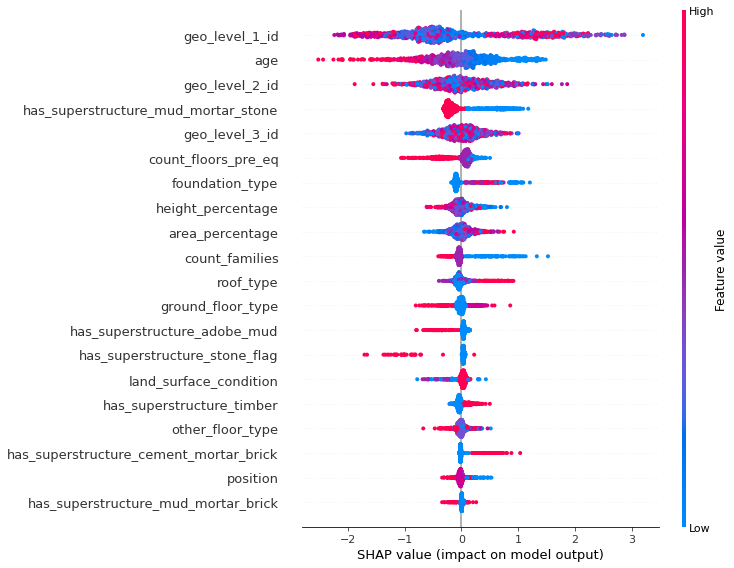

In [ ]:
shap.summary_plot(shap_values[0][:1000], x_train[:1000])

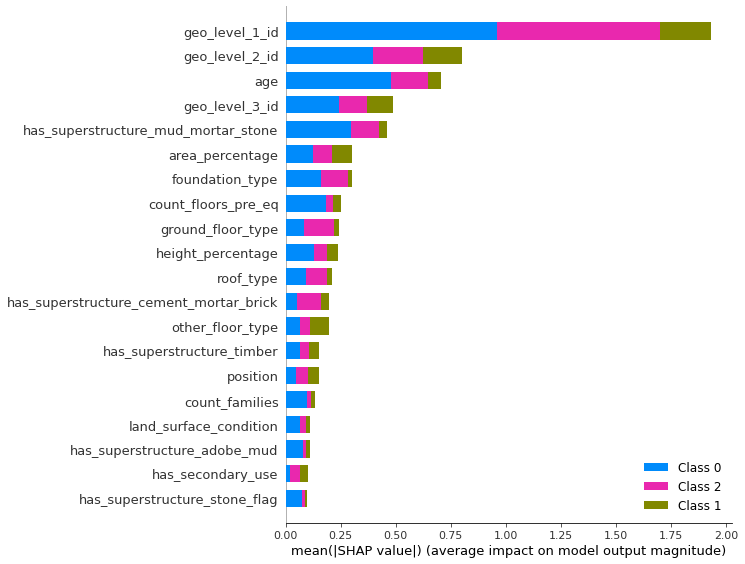

In [ ]:
shap.summary_plot(shap_values, x_train)

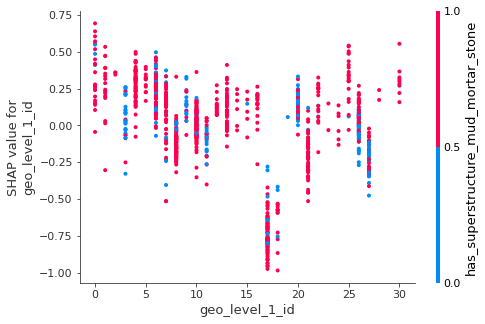

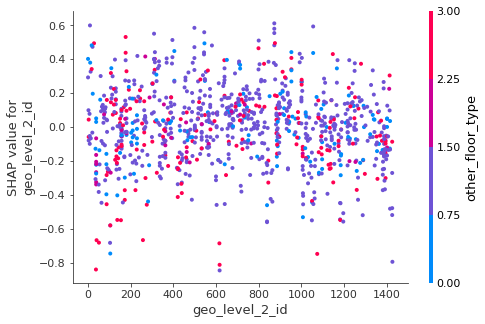

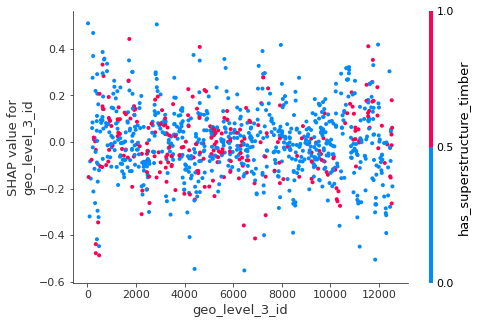

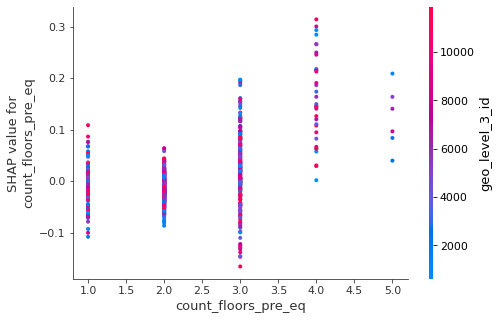

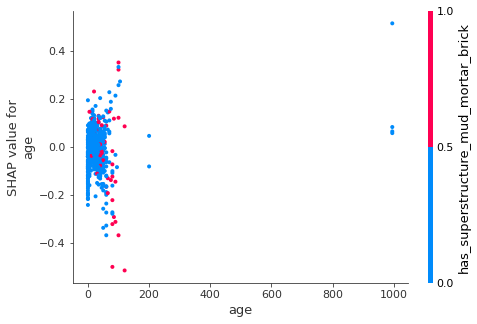

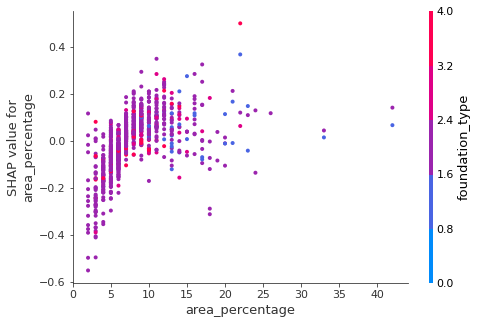

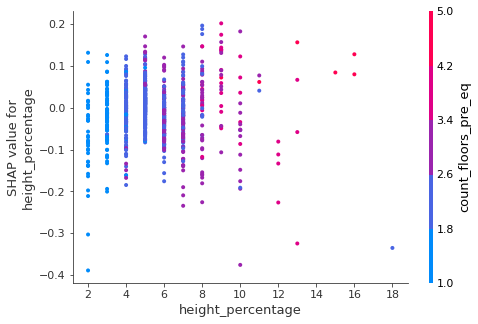

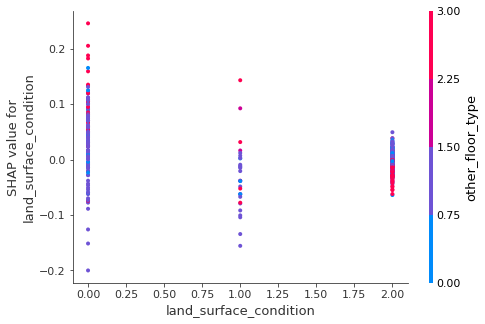

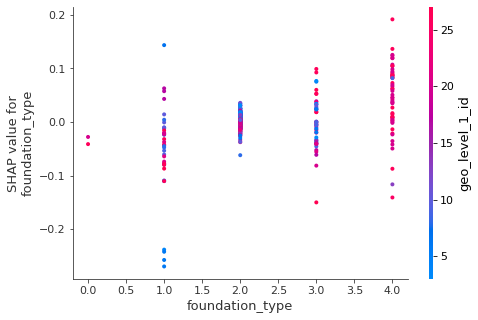

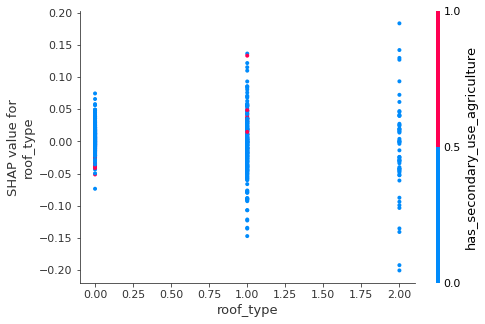

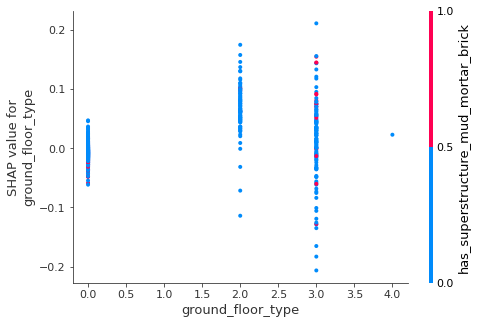

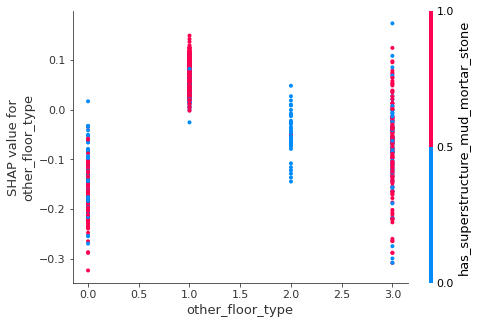

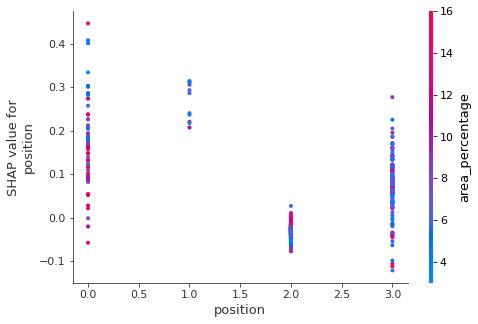

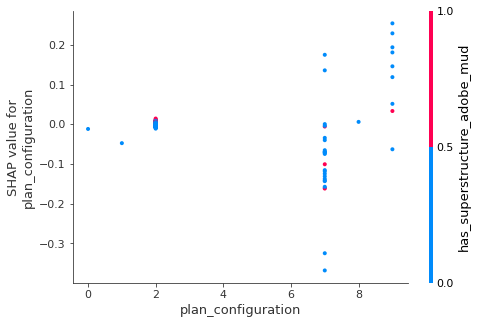

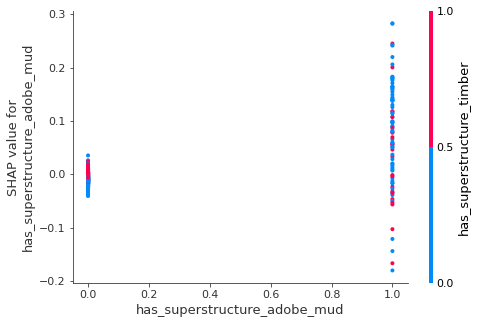

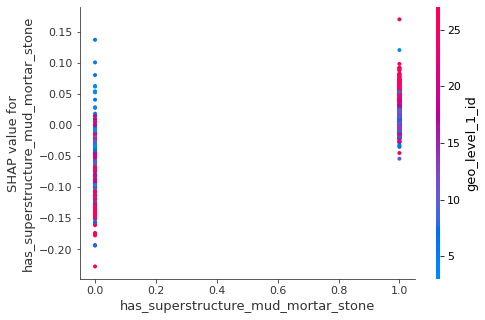

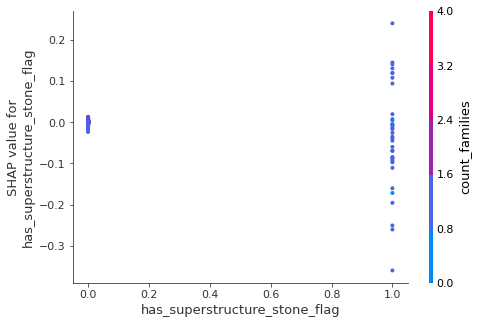

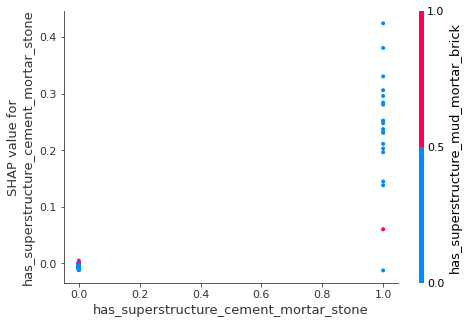

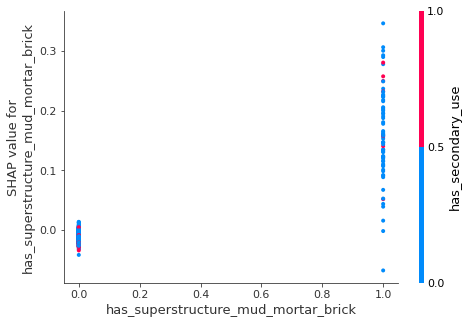

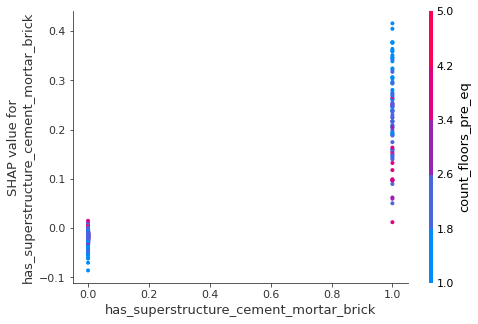

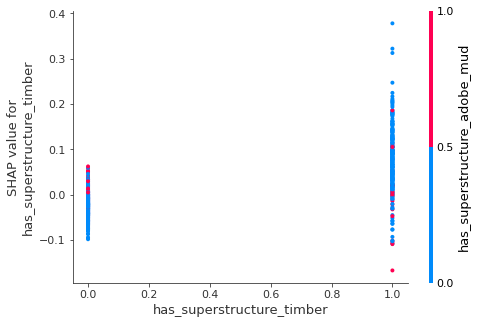

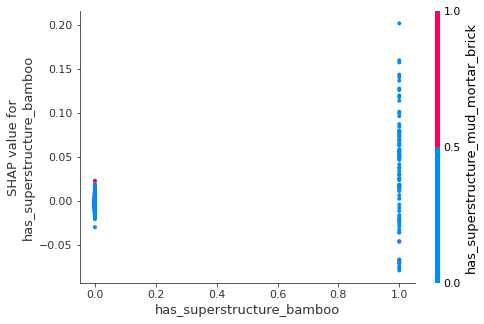

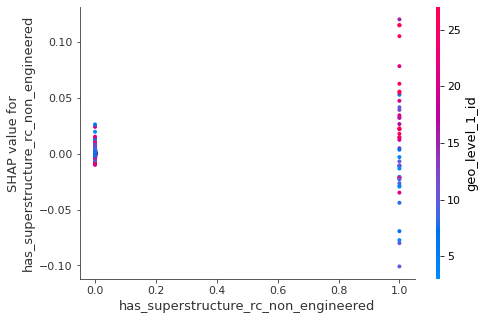

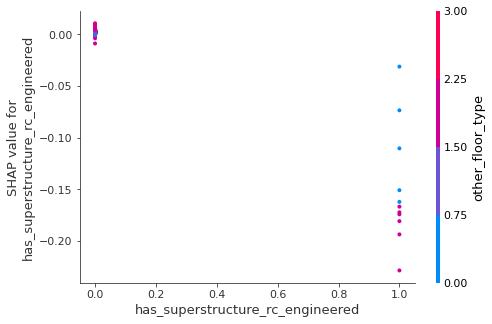

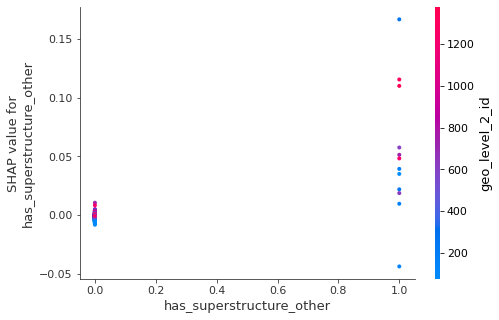

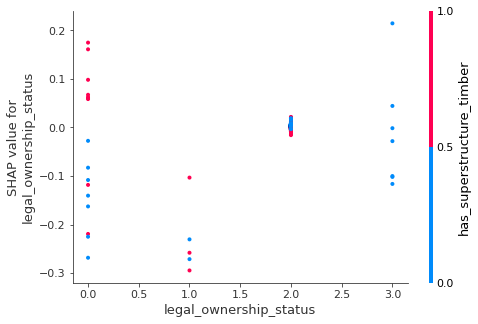

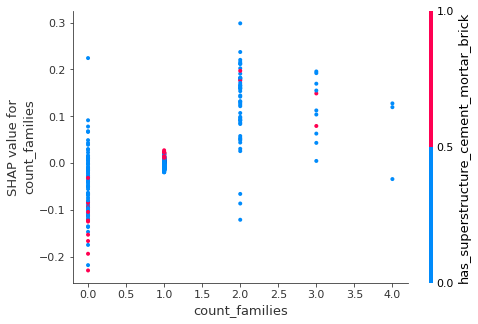

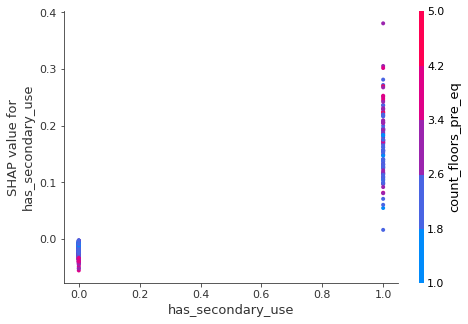

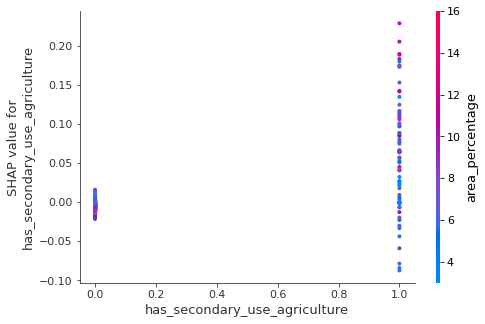

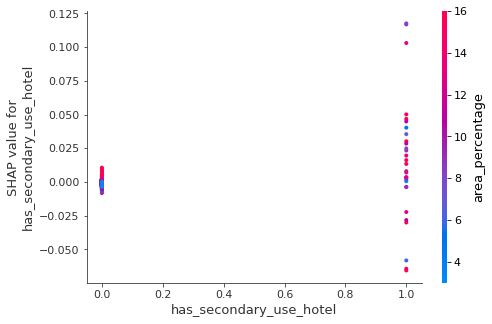

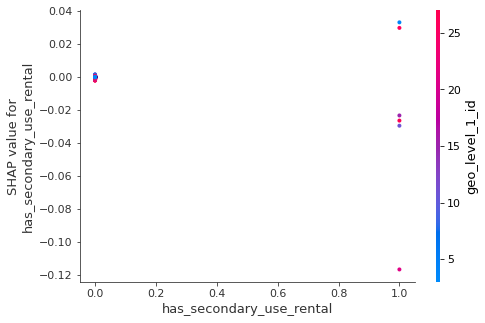

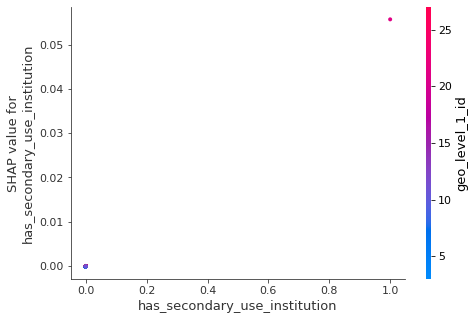

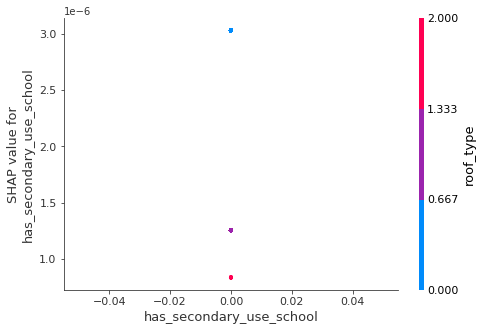

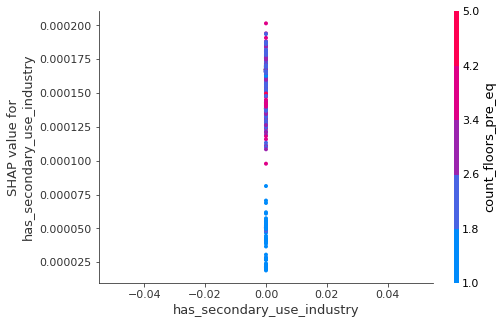

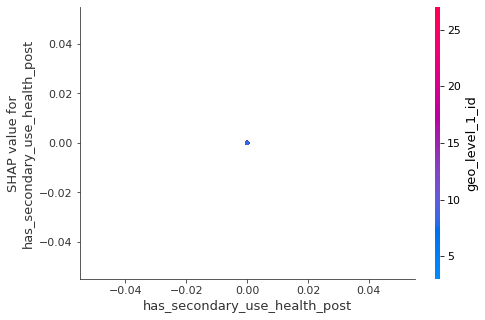

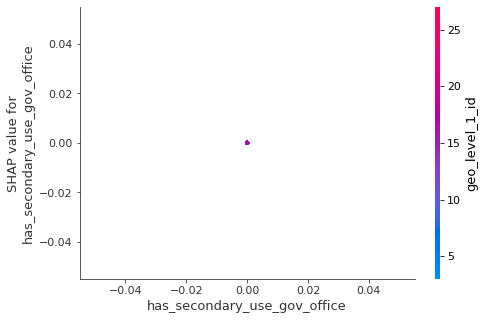

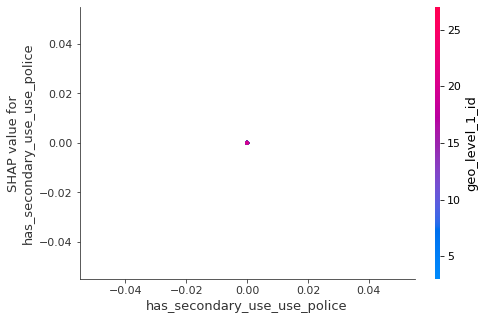

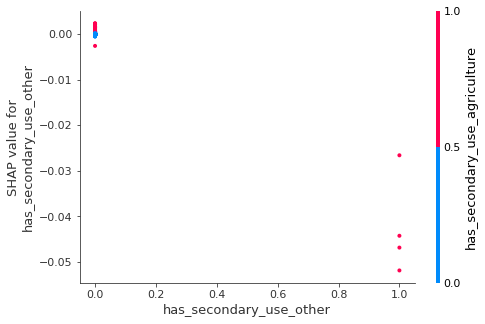

In [ ]:
for name in x_train.columns:
    shap.dependence_plot(name, shap_values[1][:1000], x_train[:1000])

In [ ]:
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)

In [ ]:
balancear = x_train.merge(y_train,right_index = True,left_index=True)
balancear["damage_grade"].value_counts()

2    103812
3     60985
1     17623
Name: damage_grade, dtype: int64

In [ ]:
balance_2 = balancear[balancear['damage_grade']==2][:17623]
balance_1 = balancear[balancear['damage_grade']==1][:17623]
balance_3 = balancear[balancear['damage_grade']==3][:17623]

balancear_final = pd.DataFrame()
balancear_final

""


In [ ]:
balancear_final=balancear_final.append(balance_2).append(balance_1).append(balance_3)

In [ ]:
x_train = balancear_final.drop(columns=['damage_grade'])

In [ ]:
y_train = balancear_final.reset_index()[['building_id','damage_grade']].set_index('building_id')

In [ ]:
y_train['damage_drade'] = y_train['damage_grade']-1

In [ ]:
y_train = y_train.drop(columns=['damage_grade'])

In [ ]:
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)

In [ ]:
model_ind = lgb.train(best_3, d_train , 20000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 52869, number of used features: 35
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.61 MB) transferred to GPU in 0.002105 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: -237.428


In [ ]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(x_train)

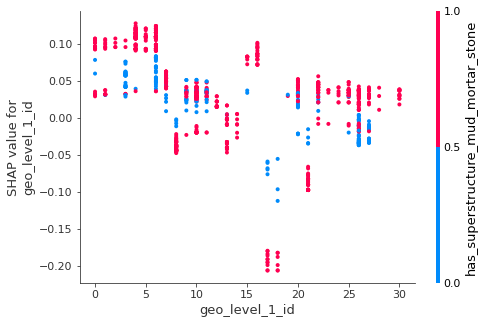

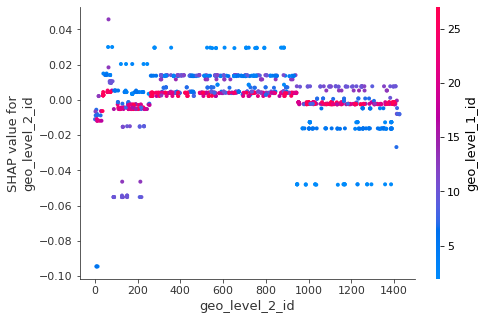

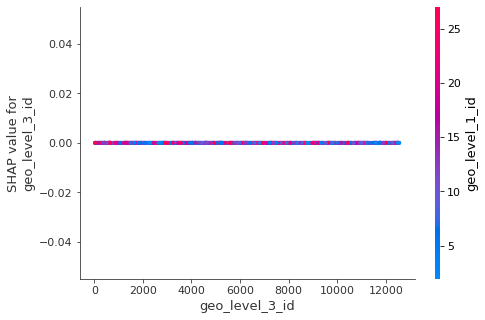

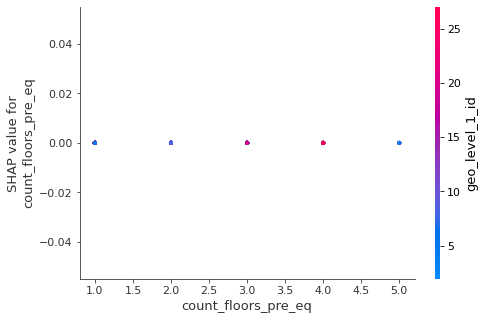

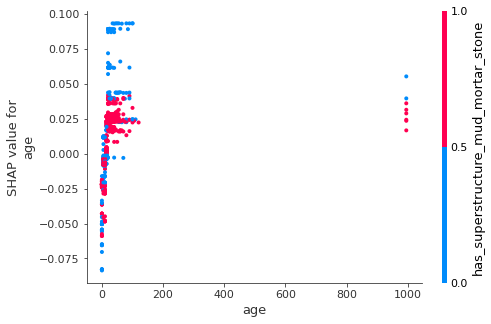

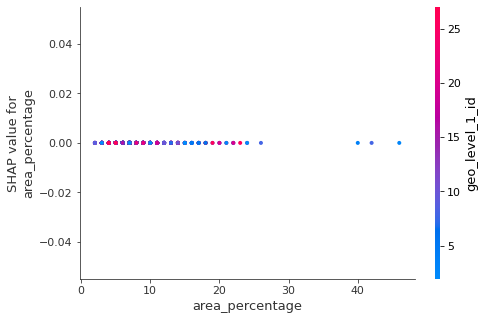

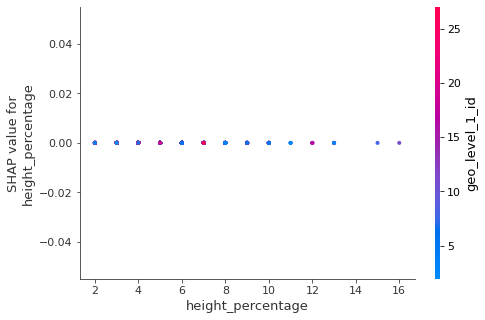

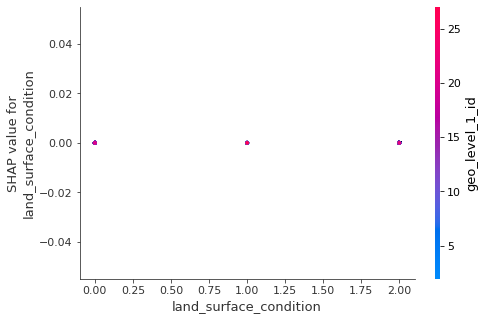

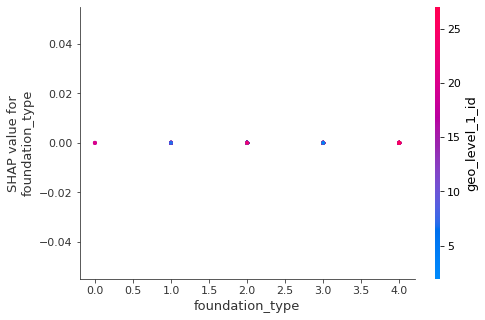

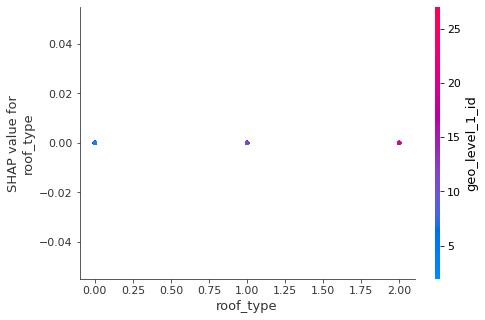

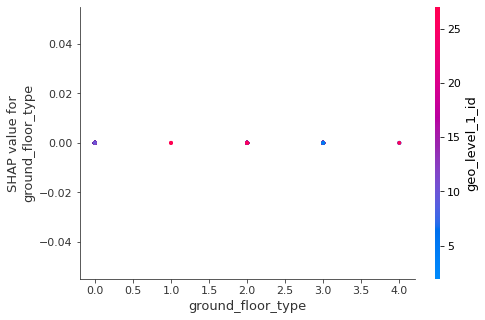

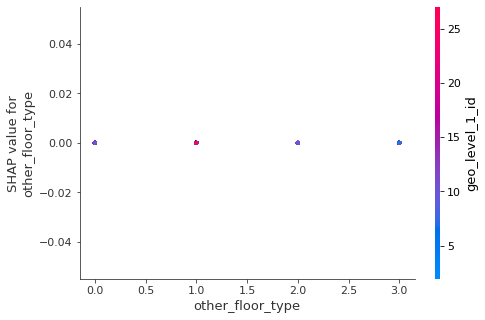

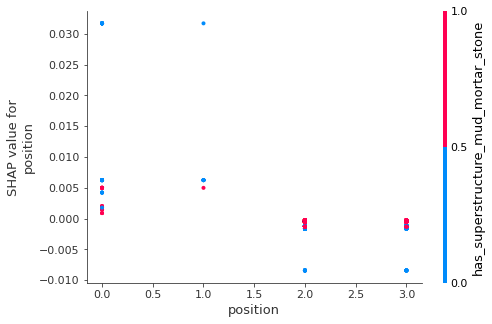

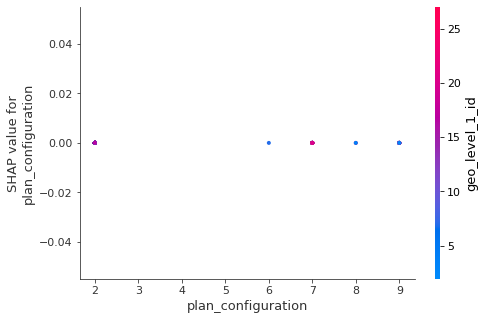

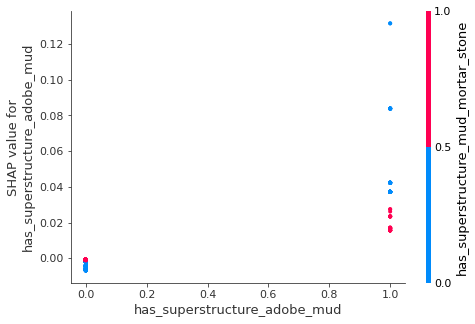

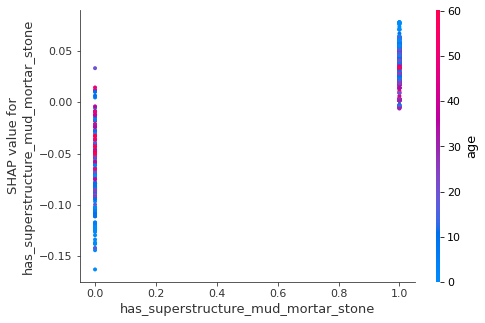

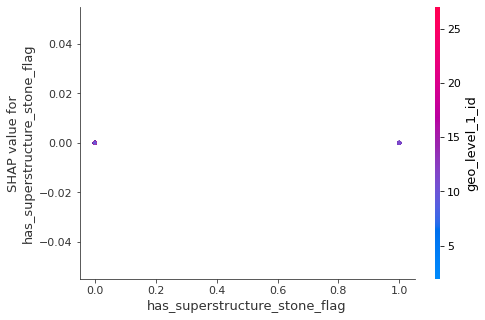

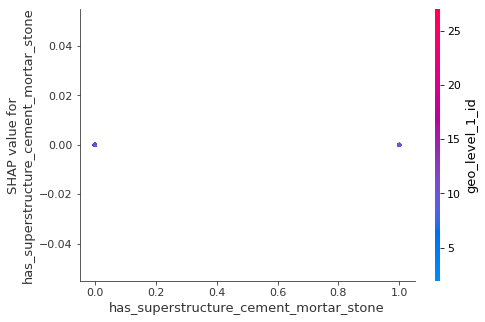

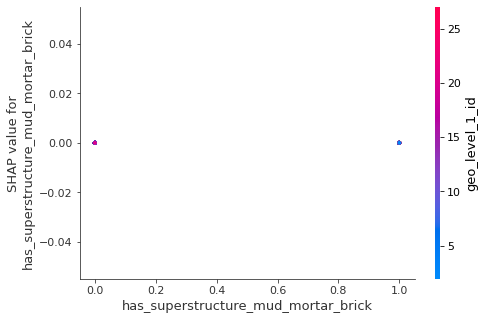

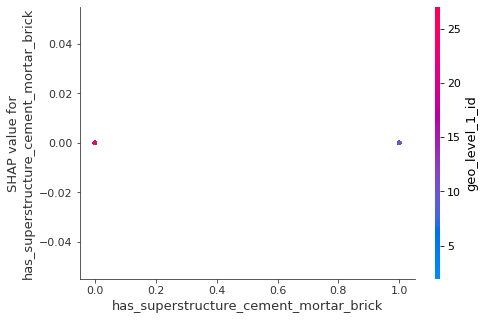

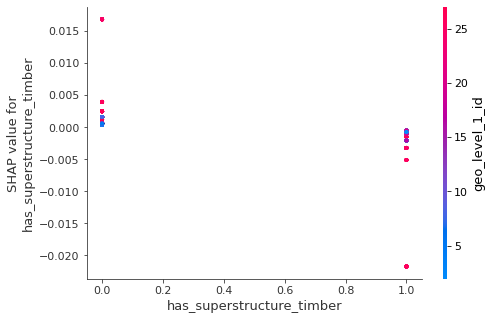

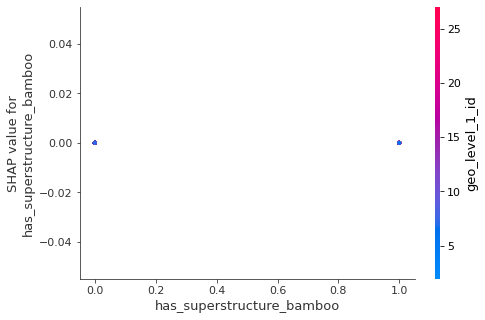

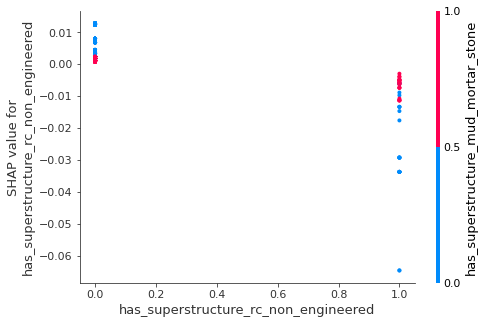

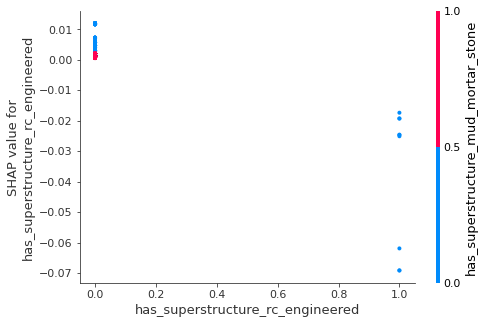

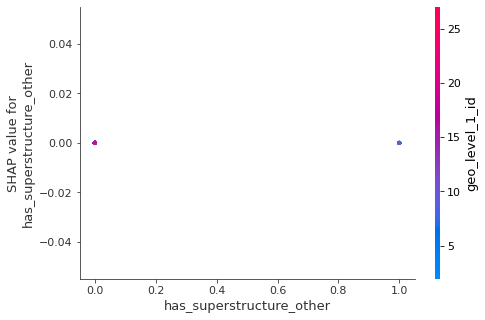

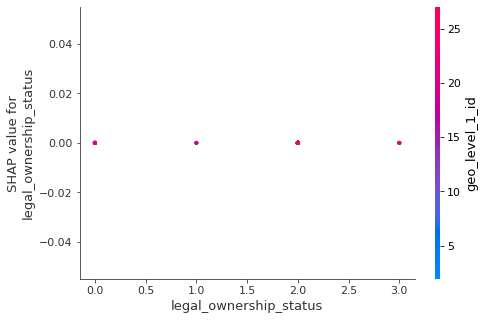

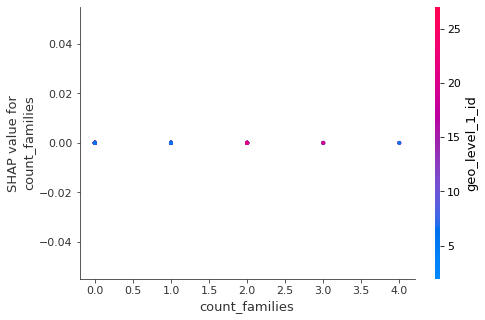

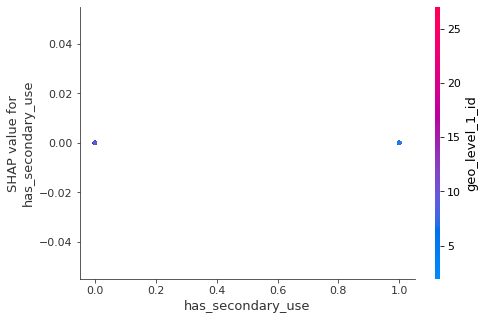

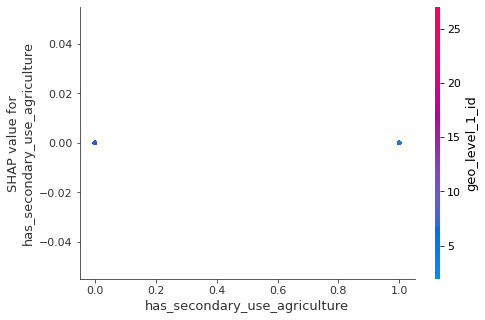

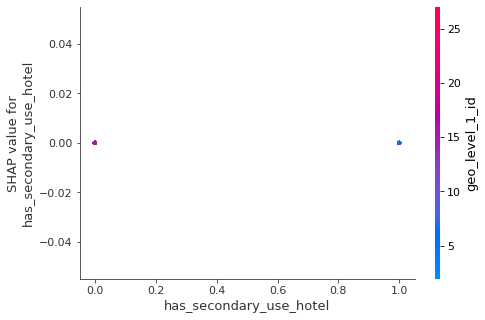

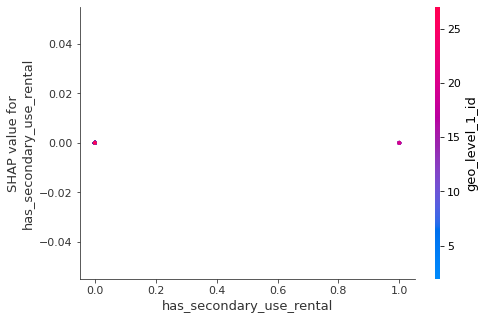

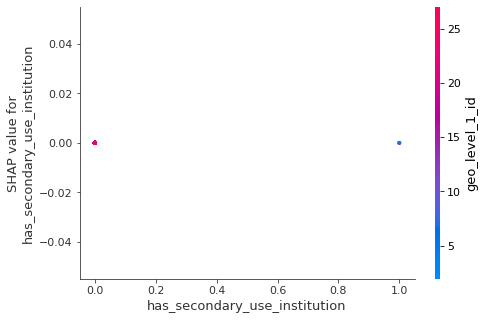

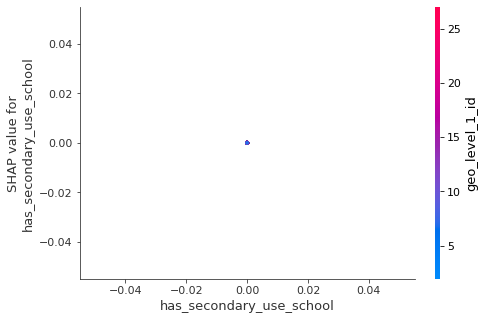

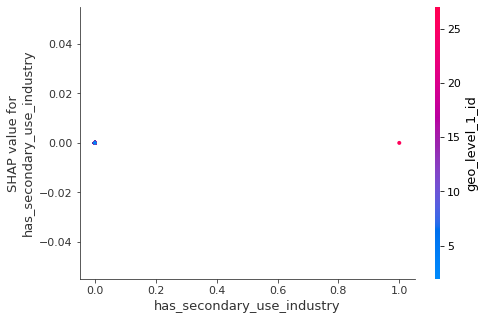

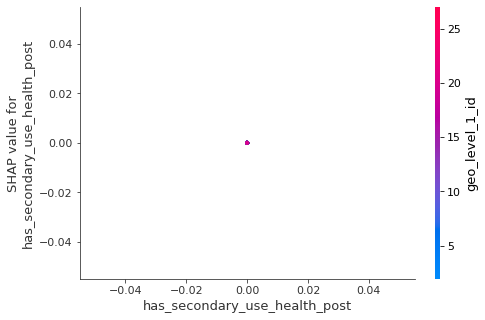

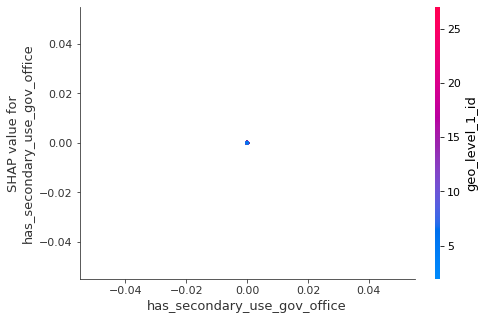

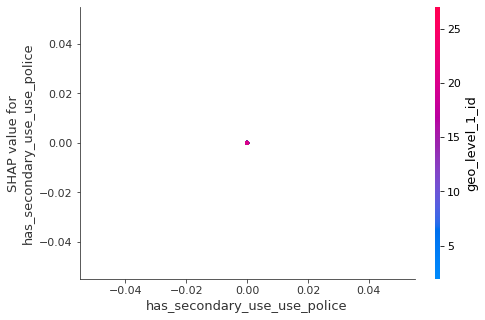

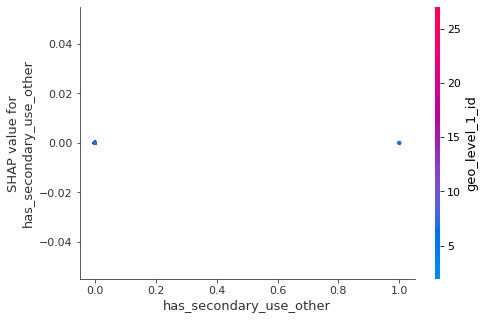

In [ ]:
for name in x_train.columns:
    shap.dependence_plot(name, shap_values_ind[1][:1000], x_train[:1000])

In [ ]:
y_pred = model_ind.predict(x_test)

In [ ]:
y_pred

array([[0.29600946, 0.31566266, 0.38832788],
       [0.30431126, 0.34472163, 0.35096711],
       [0.47231432, 0.26924219, 0.2584435 ],
       ...,
       [0.43768355, 0.28294207, 0.27937438],
       [0.31651834, 0.33433387, 0.34914779],
       [0.24806484, 0.35207012, 0.39986504]])